<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/Spend_break_out_acq_and_appeals_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
!pip install git+https://github.com/pymc-labs/pymc-marketing.git

  Cloning https://github.com/pymc-labs/pymc-marketing.git to /tmp/pip-req-build-a521bqe_
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-labs/pymc-marketing.git /tmp/pip-req-build-a521bqe_
  Resolved https://github.com/pymc-labs/pymc-marketing.git to commit 4d8b8cf7141ce9d63ba1930ff2751b52483b2e2e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [173]:
!pip install numpyro


In [174]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import numpyro

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation, MichaelisMentenSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
import pymc_marketing
print(pymc_marketing.__version__)

0.12.0


In [176]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [178]:
df_daily = pd.read_csv(
    path_ + "cafb_donations_thru_2024.csv",
    parse_dates=["Date"],
    index_col=["Date"]
)

df_daily.index = pd.to_datetime(df_daily.index)

df_daily["iso_week"] = df_daily.index.isocalendar().week
df_daily["iso_year"] = df_daily.index.isocalendar().year

print(df_daily.loc["2024-12-01":"2024-12-05"])


# Create columns week_43..week_52
for w in range(43, 53):
    col = f"week_{w}"
    df_daily[col] = 0.0
    mask = df_daily["iso_week"] == w
    df_daily.loc[mask, col] = 1.0

df_daily["giving_tuesday"] = 0.0
df_daily["end_of_year"] = 0.0

# Mark giving_tuesday day(s)
giving_tuesday_dates = [
    pd.Timestamp('2022-11-29'),
    pd.Timestamp('2023-11-28'),
    pd.Timestamp('2024-12-03'),
]
df_daily.loc[df_daily.index.isin(giving_tuesday_dates), "giving_tuesday"] = 1.0
df_daily["giving_tuesday"] = df_daily["giving_tuesday"].astype(float)


# Zero out the corresponding week column for those single days
for dt in giving_tuesday_dates:
    iso_wk = df_daily.loc[dt, "iso_week"]  # e.g. 49
    col = f"week_{iso_wk}"
    df_daily.loc[dt, col] = 0.0

# Mark end_of_year
mask_eoy = (df_daily.index.month == 12) & (df_daily.index.day == 31)
df_daily.loc[mask_eoy, "end_of_year"] = 1.0

# Zero out the corresponding week column for those EOY days
df_daily.loc[mask_eoy, "week_52"] = 0.0  # if EOY is in iso week 52
# or do the same approach with .loc for the iso_week

df_dummies = df_daily.resample("W").max()

# Now you have columns ["week_43","week_44",..., "week_52","giving_tuesday","end_of_year"] in df_weekly
print(df_dummies[["giving_tuesday","week_49"]].loc["2024-12-01":"2024-12-10"])


              Revenue  iso_week  iso_year
Date                                     
2024-12-01   71125.80        48      2024
2024-12-02  117976.34        49      2024
2024-12-03  393562.23        49      2024
2024-12-04   98450.85        49      2024
2024-12-05   51820.32        49      2024
            giving_tuesday  week_49
Date                               
2024-12-01             0.0      0.0
2024-12-08             1.0      1.0


In [179]:
# prompt: drop revenue from df_dummies

# Assuming 'Revenue' is the column name you want to drop.
# If it's different, replace 'Revenue' with the actual column name.
if 'Revenue' in df_dummies.columns:
    df_dummies = df_dummies.drop(columns=['Revenue'])

In [180]:
# prompt: print average weekly revenue by iso_week

# Calculate the average weekly revenue by iso_week
df_daily.groupby('iso_week')['Revenue'].sum()




,Revenue
iso_week,
1,1826985.92
2,373735.10
3,400239.61
4,409734.55
5,390319.77
6,265698.86
7,270529.07
8,274770.87
9,572850.51


In [181]:
#stop

In [182]:
df_weekly = df_daily['Revenue'].resample('W').sum()
avg_weekly = df_weekly.groupby(df_weekly.index.isocalendar().week).mean()
print(avg_weekly.apply(lambda x: f"{x:,.0f}"))



week
1       456,746
2       124,578
3       133,413
4       136,578
5       130,107
6        88,566
7        90,176
8        91,590
9       190,950
10      123,621
11      103,262
12      116,033
13       99,935
14      119,161
15      104,546
16       94,498
17       99,133
18      111,554
19       93,306
20      104,885
21       91,006
22      105,380
23      100,456
24       77,963
25       84,503
26      131,138
27       79,387
28      101,159
29      108,598
30       96,865
31      117,162
32      102,646
33       71,988
34       93,509
35      114,073
36      112,060
37      107,514
38       91,028
39      146,136
40      102,164
41      126,998
42      130,336
43      136,046
44      170,892
45      246,137
46      345,142
47      316,389
48      681,088
49      602,848
50      692,570
51      816,671
52    1,336,506
Name: Revenue, dtype: object


In [183]:
#stop

In [184]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()  #not updated, not in model

#dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() combined dm, not longer used in model

dm_acq = pd.read_csv(path_+'dm_acquisition.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm_appeals = pd.read_csv(path_+'dm_appeal.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()

sales = pd.read_csv(path_+'cafb_donations_thru_2024.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()


email = pd.read_csv(path_+'cafb_email_20241231.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated

fb = pd.read_csv(path_+'cafb_meta_20241231.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated

paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #not in model

prog = pd.read_csv(path_+'cafb_programmatic_20250205.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated

ftf = pd.read_csv(path_+'cafb_ftf_20241231.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #updated


ga4 = pd.read_csv(path_+'cafb_ga4_sessions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum() #not in model



In [185]:
consumer_demand = pd.read_excel(path_+'Economic Data_v3.xlsx', sheet_name='Consumer_Demand', index_col=None)
consumer_demand = consumer_demand.set_index('Date')
consumer_demand.tail()

,Consumer_Demand
Date,
2025-01-26,14
2025-02-02,26
2025-02-09,25
2025-02-16,18
2025-02-23,21


In [186]:
df = pd.concat([bing, dm_acq, dm_appeals, email, fb, paid_search, prog, ftf ,sales, consumer_demand, df_dummies], axis=1).fillna(0).head(158).reset_index()
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df.head(2)

,Date,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Acq_Impressions,DM_Acq_Spend,DM_Appeal_Impressions,DM_Appeal_Spend,Email_Impressions,...,week_45,week_46,week_47,week_48,week_49,week_50,week_51,week_52,giving_tuesday,end_of_year
0,2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,60000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [187]:
df['GoogleAds_Impressions'] = df['GoogleAds_Branded_Impressions'] + df['GoogleAds_NonBranded_Impressions']
df['GoogleAds_Spend'] = df['GoogleAds_Branded_Spend'] + df['GoogleAds_NonBranded_Spend']

df['Bing_Impressions'] = df['Bing_Branded_Impressions'] + df['Bing_NonBranded_Impressions']
df['Bing_Spend'] = df['Bing_Branded_Spend'] + df['Bing_NonBranded_Spend']

In [188]:
df["november"] = df["Date"].apply(lambda x: 1 if x.month in [11] else 0)
df["december"] = df["Date"].apply(lambda x: 1 if x.month in [12] else 0)
#df["end_of_year"] = ((df["Date"].dt.month == 12) & (df["Date"].dt.day == 31)) | ((df["Date"].dt.month == 1) & (df["Date"].dt.day == 1))
#df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")
#fix trend
df['trend'] = df['Consumer_Demand']


In [189]:
df['log_Revenue'] = np.log(df['Revenue'] + 1)
df['Month'] = df['Date'].dt.month
monthly_avg_revenue = df.groupby('Month')['log_Revenue'].mean()
monthly_avg_revenue

,log_Revenue
Month,
1,11.844888
2,11.470026
3,11.702457
4,11.530205
5,11.504213
6,11.426302
7,11.489680
8,11.425816
9,11.557955


In [190]:

# prompt: please provide the average revenue for each of these dummies  'week_43',
#  'week_44',
#  'week_45',
#  'week_46',
#  'week_47',
#  'week_48',
#  'week_49',
#  'week_50',
#  'week_51',
#  'week_52',
#  'giving_tuesday',
#  'end_of_year',

# Calculate the average revenue for each dummy variable
dummy_cols = ['week_43', 'week_44', 'week_45', 'week_46', 'week_47', 'week_48', 'week_49', 'week_50', 'week_51', 'week_52', 'giving_tuesday', 'end_of_year']
for col in dummy_cols:
    avg_revenue = df[df[col] >= 1]['Revenue'].mean()
    print(f"Average revenue for {col}: {avg_revenue}")


Average revenue for week_43: 136046.28333333335
Average revenue for week_44: 170891.53333333333
Average revenue for week_45: 246136.77666666664
Average revenue for week_46: 345142.5
Average revenue for week_47: 316389.12666666665
Average revenue for week_48: 681087.61
Average revenue for week_49: 602848.2366666667
Average revenue for week_50: 692570.47
Average revenue for week_51: 816671.4500000001
Average revenue for week_52: 1336505.6075000002
Average revenue for giving_tuesday: 792550.18
Average revenue for end_of_year: 2123718.3200000003


In [191]:
# prompt: provide the avg revenue by month

# Calculate the average revenue for each month
df['Month'] = df['Date'].dt.month
monthly_avg_revenue = df.groupby('Month')['Revenue'].mean()/3
monthly_avg_revenue


,Revenue
Month,
1,120782.552000
2,33369.960278
3,43669.994359
4,34385.324103
5,33628.513590
6,32317.320513
7,33237.323095
8,32108.845833
9,36434.517949


<ipython-input-192-1a5ac69e9fc7>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


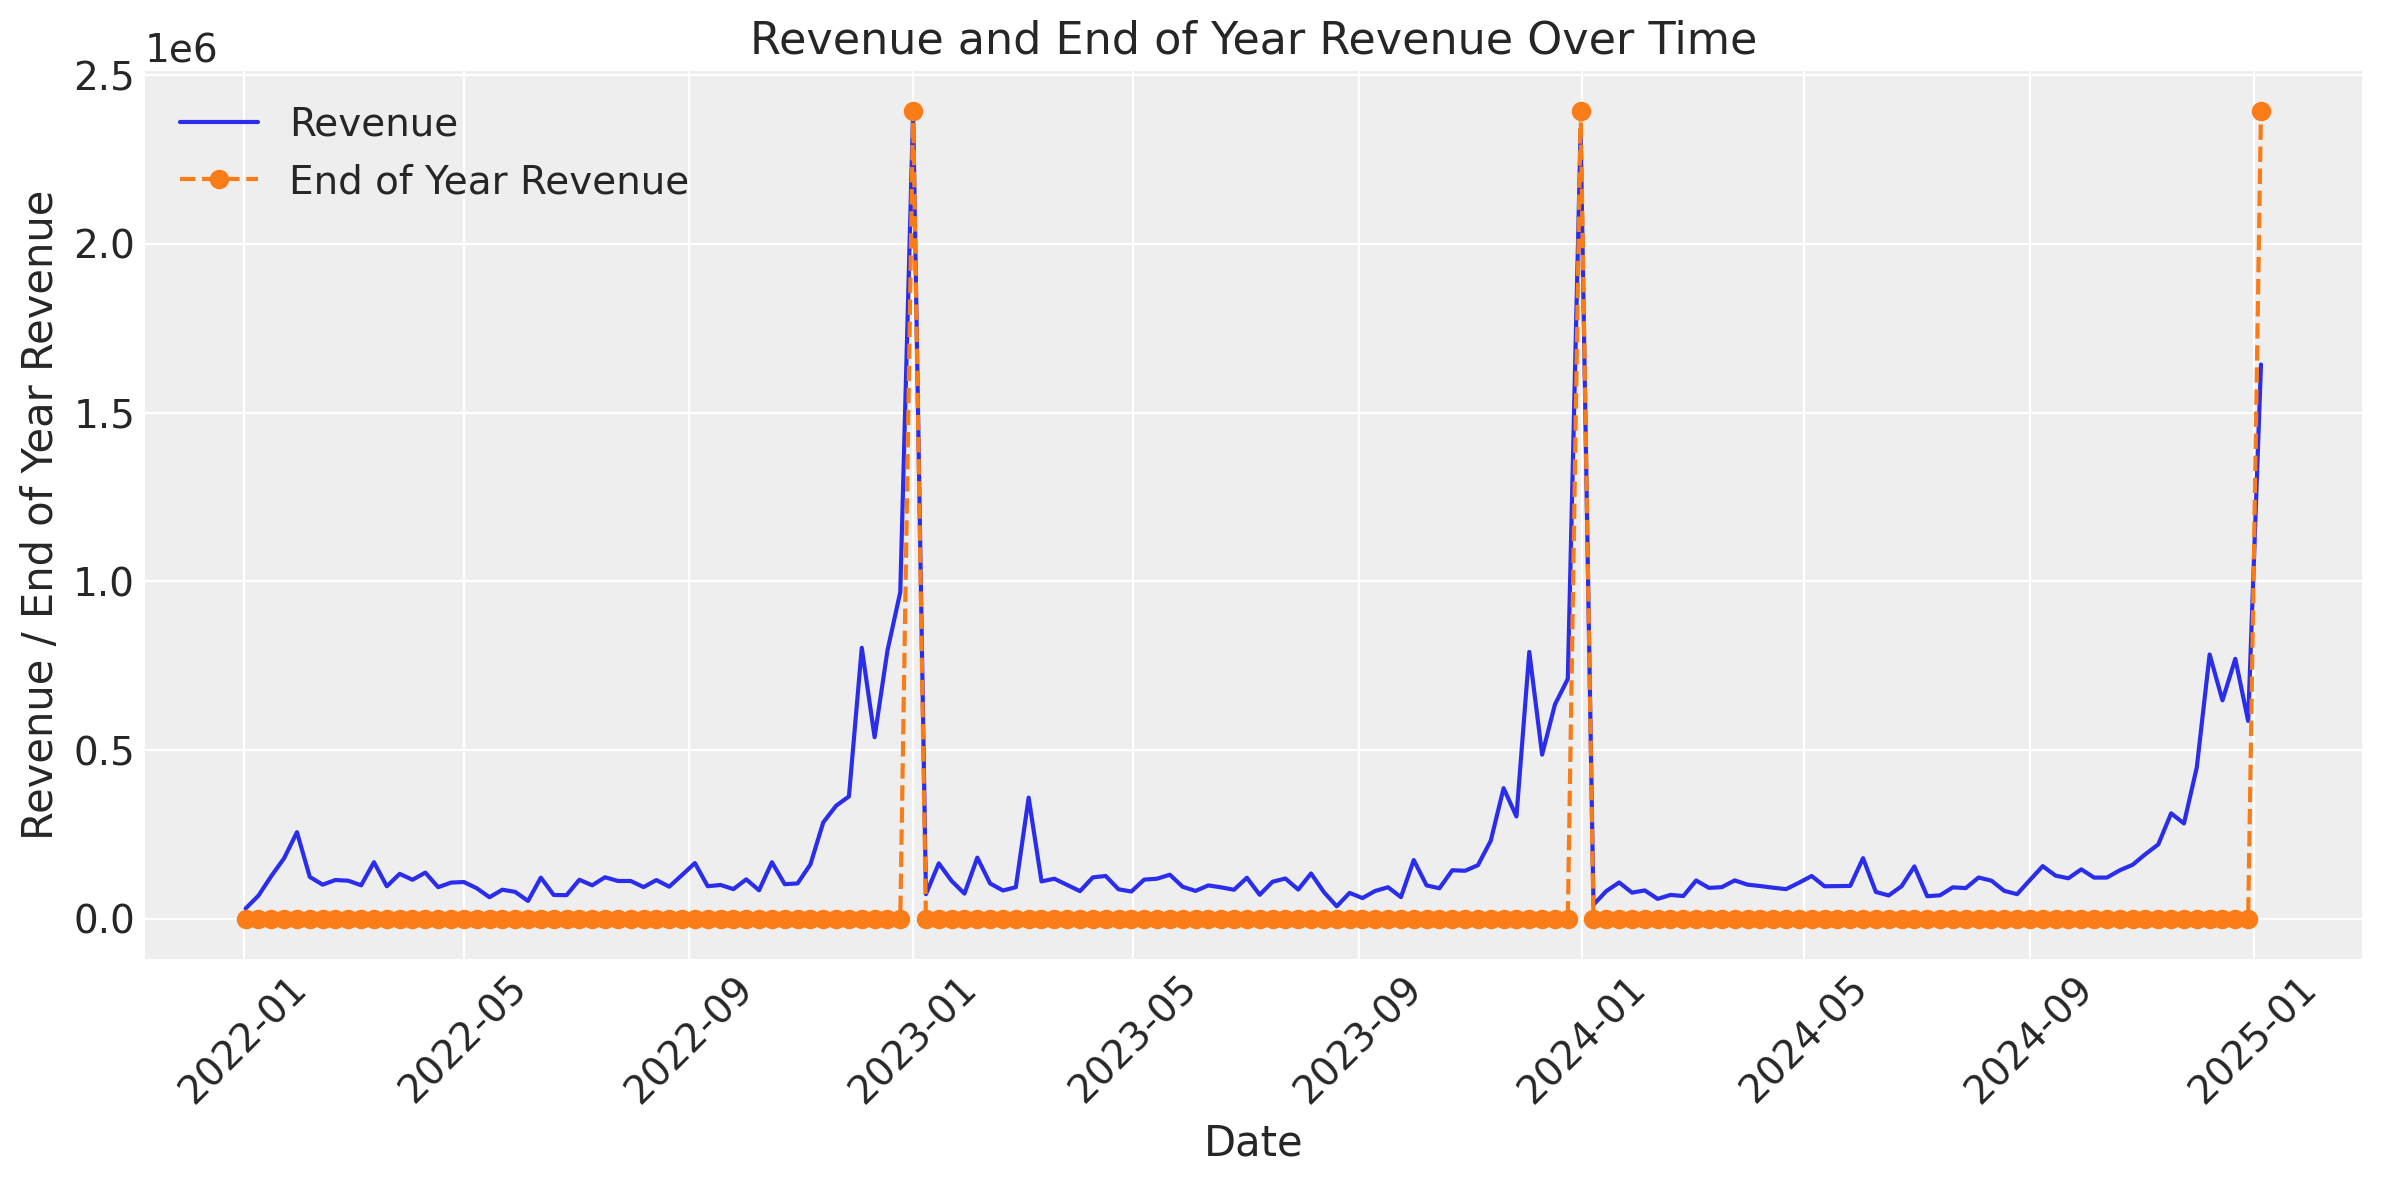

In [192]:
# prompt: generate chart with Date as x axis and revenue and end of year on y axis

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame as defined in the previous code

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Revenue'], label='Revenue')
plt.plot(df['Date'], df['end_of_year'] * df['Revenue'].max(), label='End of Year Revenue', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue / End of Year Revenue')
plt.title('Revenue and End of Year Revenue Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [193]:
df_ = df.set_index('Date')
input_df = df_[['Revenue', *[c for c in df_.columns if 'Impressions' in c], "week_46","week_47","week_48",  "week_49","week_50","week_51","giving_tuesday","end_of_year", 'november', 'december']]
spend_df = df_[['Revenue', *[c for c in df_.columns if 'Spend' in c], "week_46","week_47","week_48",  "week_49","week_50","week_51","giving_tuesday","end_of_year", 'november', 'december']]

In [194]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


df = spend_df.copy()
#df = input_df.copy()
df = df.reset_index()

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 158


In [195]:
data = df.copy()
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [196]:
#data["Revenue"].describe()

In [197]:
data.dtypes

,0
Date,datetime64[ns]
Revenue,float64
Bing_Branded_Spend,float64
Bing_NonBranded_Spend,float64
DM_Acq_Spend,float64
DM_Appeal_Spend,float64
Email_Spend,float64
FB_Spend,float64
GoogleAds_Branded_Spend,float64
GoogleAds_NonBranded_Spend,float64


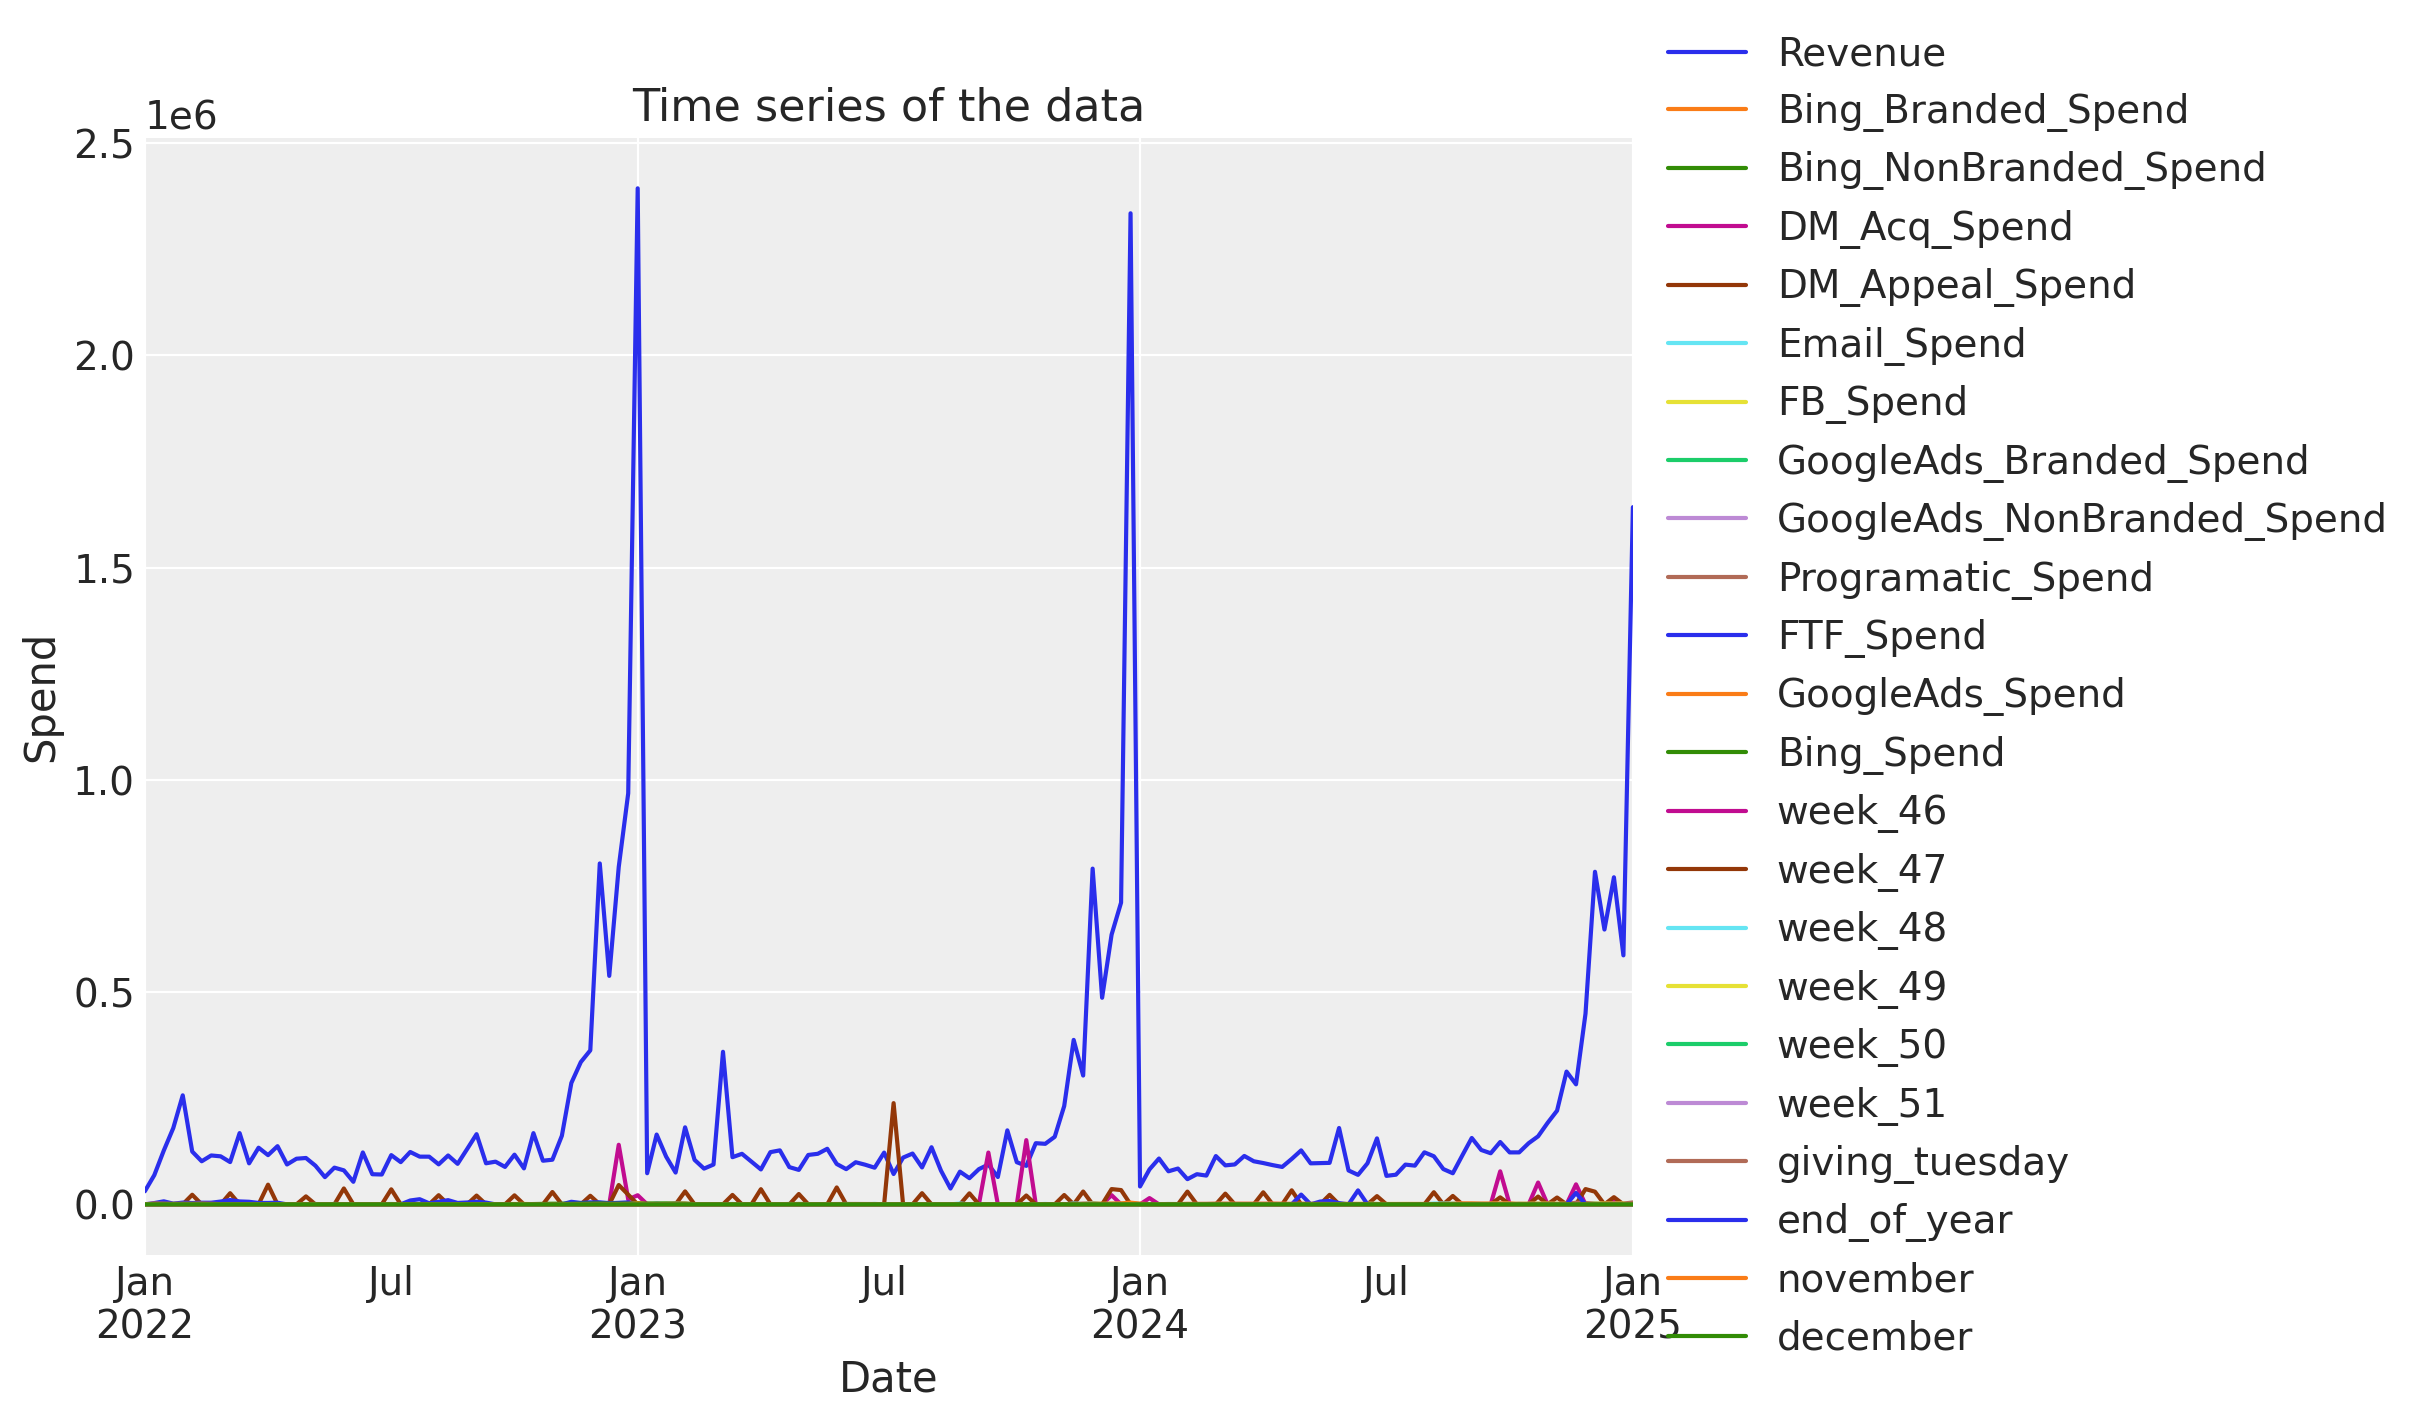

In [198]:
fig, ax = plt.subplots()
data.set_index("Date").plot(ax=ax)
ax.set_title("Time series of the data")
ax.set_ylabel("Spend")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

In [199]:
# prompt: What is my average weekly spend for each channel

# Calculate weekly spend for each channel
weekly_spend = df.groupby('Date')[[col for col in df.columns if 'Spend' in col]].sum()

# Calculate the average weekly spend for each channel
average_weekly_spend = weekly_spend.mean()

average_weekly_spend


,0
Bing_Branded_Spend,134.314241
Bing_NonBranded_Spend,379.513354
DM_Acq_Spend,4241.177215
DM_Appeal_Spend,8201.664557
Email_Spend,405.063291
FB_Spend,440.906899
GoogleAds_Branded_Spend,268.872298
GoogleAds_NonBranded_Spend,484.645973
Programatic_Spend,396.362152
FTF_Spend,1629.531646


In [200]:
ch = [ 'DM_Appeal_Spend', 'DM_Acq_Spend', 'Email_Spend',
       'FB_Spend',  'Programatic_Spend',
       'FTF_Spend']

#df[ch] = np.log(df[ch] + 1)




X = data.drop("Revenue", axis=1)
y = data["Revenue"]

print("First few rows of X:")
print(X.head())

print("\nFirst few rows of y (should be log scale):")
print(y.head())

print("\nStatistics on y:")
print(y.describe())




First few rows of X:
        Date  Bing_Branded_Spend  Bing_NonBranded_Spend  DM_Acq_Spend  \
0 2022-01-02                3.26                 210.97           0.0   
1 2022-01-09                8.25                 757.49           0.0   
2 2022-01-16                7.87                 823.99           0.0   
3 2022-01-23               20.69                 834.35           0.0   
4 2022-01-30               22.09                 835.66           0.0   

   DM_Appeal_Spend  Email_Spend  FB_Spend  GoogleAds_Branded_Spend  \
0              0.0          0.0       0.0                    86.76   
1              0.0       1000.0       0.0                   496.89   
2              0.0          0.0       0.0                   265.98   
3              0.0       1000.0       0.0                   146.24   
4              0.0          0.0       0.0                   154.49   

   GoogleAds_NonBranded_Spend  Programatic_Spend  ...  week_46  week_47  \
0                      196.73               

In [201]:
from pymc_marketing.prior import Prior
import pymc_marketing.mmm as mmm

In [202]:
#sampler_config = {"progressbar": True}

In [203]:
custom_config = {
    "intercept": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": 5}
    },
    # saturation_beta: vectorized Gamma priors for each channel.
    # Channel order: ['DM_Appeal_Spend', 'DM_Acq_Spend', 'Email_Spend', 'FB_Spend', 'Programatic_Spend', 'FTF_Spend']
    # For DM_Appeal_Spend, we set alpha=14, beta=2, so mean = 14/2 = 7.0.
    # For DM_Acq_Spend, we set alpha=8, beta=20, so mean = 8/20 = 0.4.
    # For the other channels, we use a generic prior (mean = 2/2 = 1.0).
    "saturation_beta": {
        "dist": "Gamma",
        "kwargs": {
            "alpha": [14, 2, 2, 2, 2, 2],
            "beta":  [2, 5, 2, 2, 2, 2],
        },
        "dims": "channel",
    },
    # saturation_lam: here we also supply vectorized Gamma priors.
    # For instance, you might set DM_Appeal_Spend with mean 2/4 = 0.5,
    # DM_Acq_Spend with mean 2/5 = 0.4, and the others at 2/4 = 0.5.
    "saturation_lam": {
        "dist": "Gamma",
        "kwargs": {
            "alpha": [2, 8, 2, 2, 2, 2],
            "beta":  [4, 20, 4, 4, 4, 4],
        },
        "dims": "channel",
    },
    "gamma_control": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": 2.5}
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 2}
    },
    "media_tvp_config": {
         "m": 5,
         "L": 30,
         "eta_lam": 2,
         "ls_mu": 2,
         "ls_sigma": 5,
         "cov_func": None
    },
}




media_tvp_config = {
    "media_tvp_config": {
        "m": 5,  # Reduced number of basis functions from 50
        "L": 30,  # Reduced from 30
        "eta_lam": 2,  # Increased from 2 for stronger smoothing
        "ls_mu": 2,  # Reduced from 2
        "ls_sigma": 5,  # Reduced from 5
        "cov_func": None, #"exponential"  # Added covariance function for better regularization
    }
}

custom_config = {**custom_config, **media_tvp_config}


# 1) Identify numeric columns for the model (channels, controls), but DO NOT include 'Date' in them.
#defined above
ch = [ 'DM_Appeal_Spend', 'DM_Acq_Spend', 'Email_Spend',
       'FB_Spend',  'Programatic_Spend',
       'FTF_Spend']

controls = ['end_of_year', 'november', 'december']

mmm = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=1, # 1 oer 2
    time_varying_media=True,
    time_varying_intercept=False
)


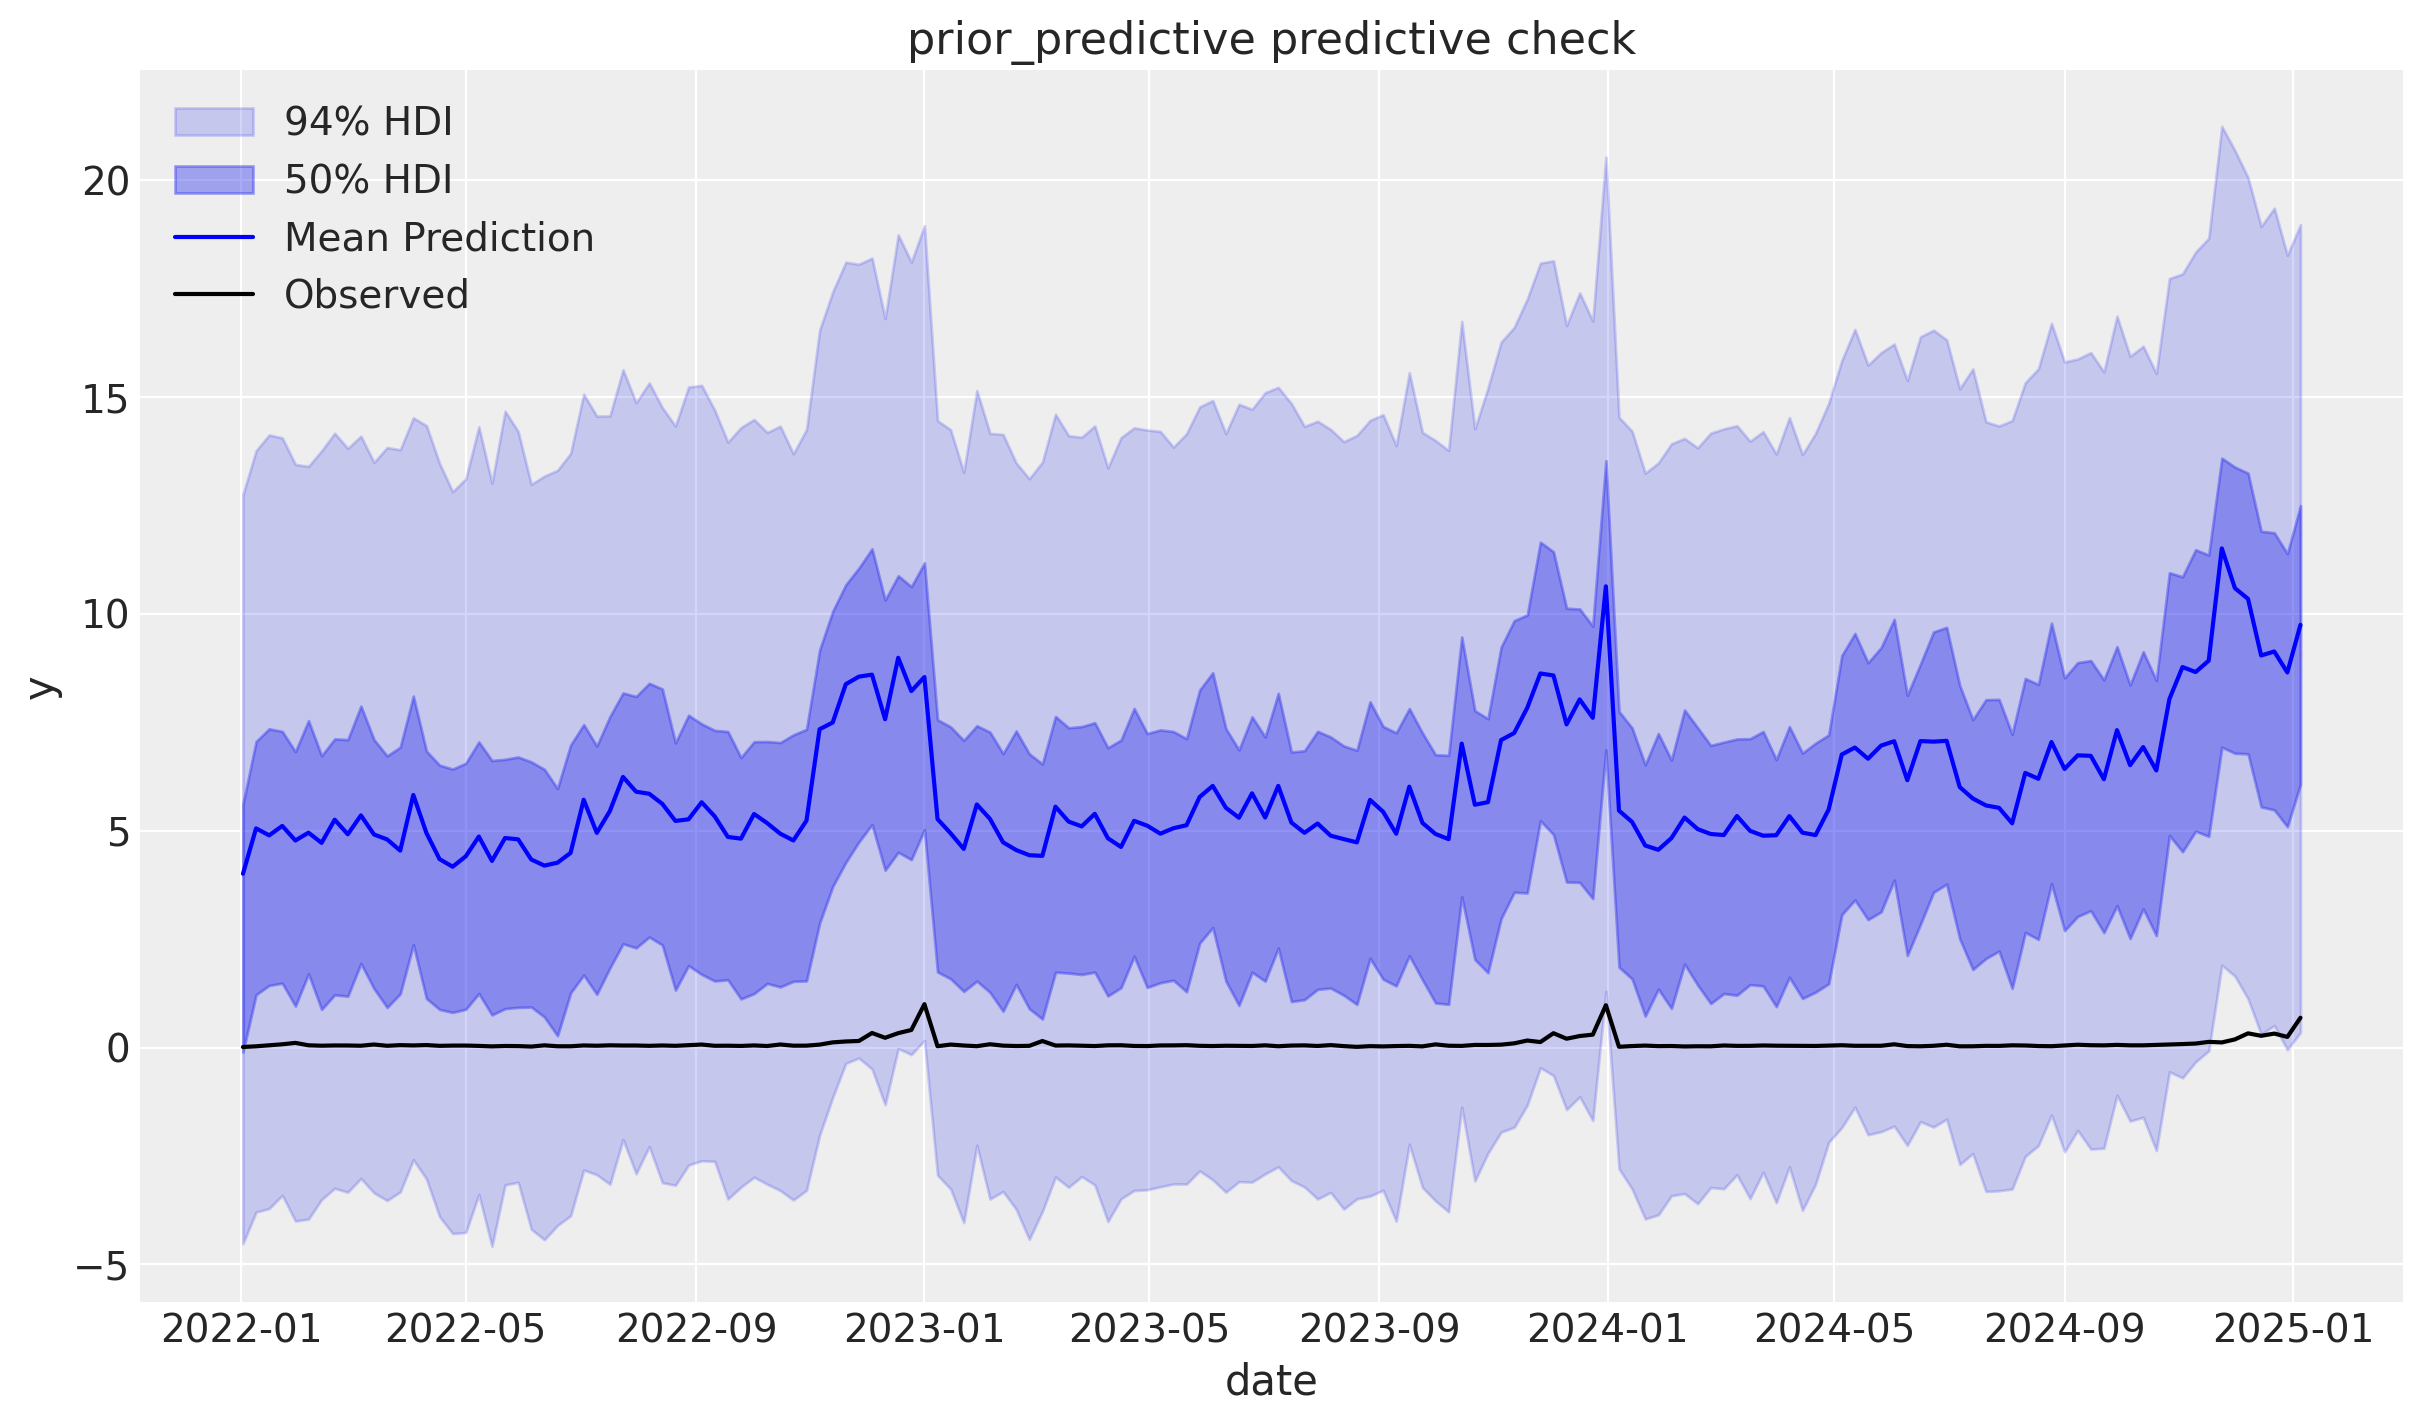

In [204]:
# Generate prior predictive samples - incorrect observed data
mmm.sample_prior_predictive(X, y, samples=6_000)

mmm.plot_prior_predictive();




In [205]:

mmm.sample_prior_predictive(X, y, samples=6000)
prior_draws = mmm.prior_predictive["y"]  # or however your MMM returns it



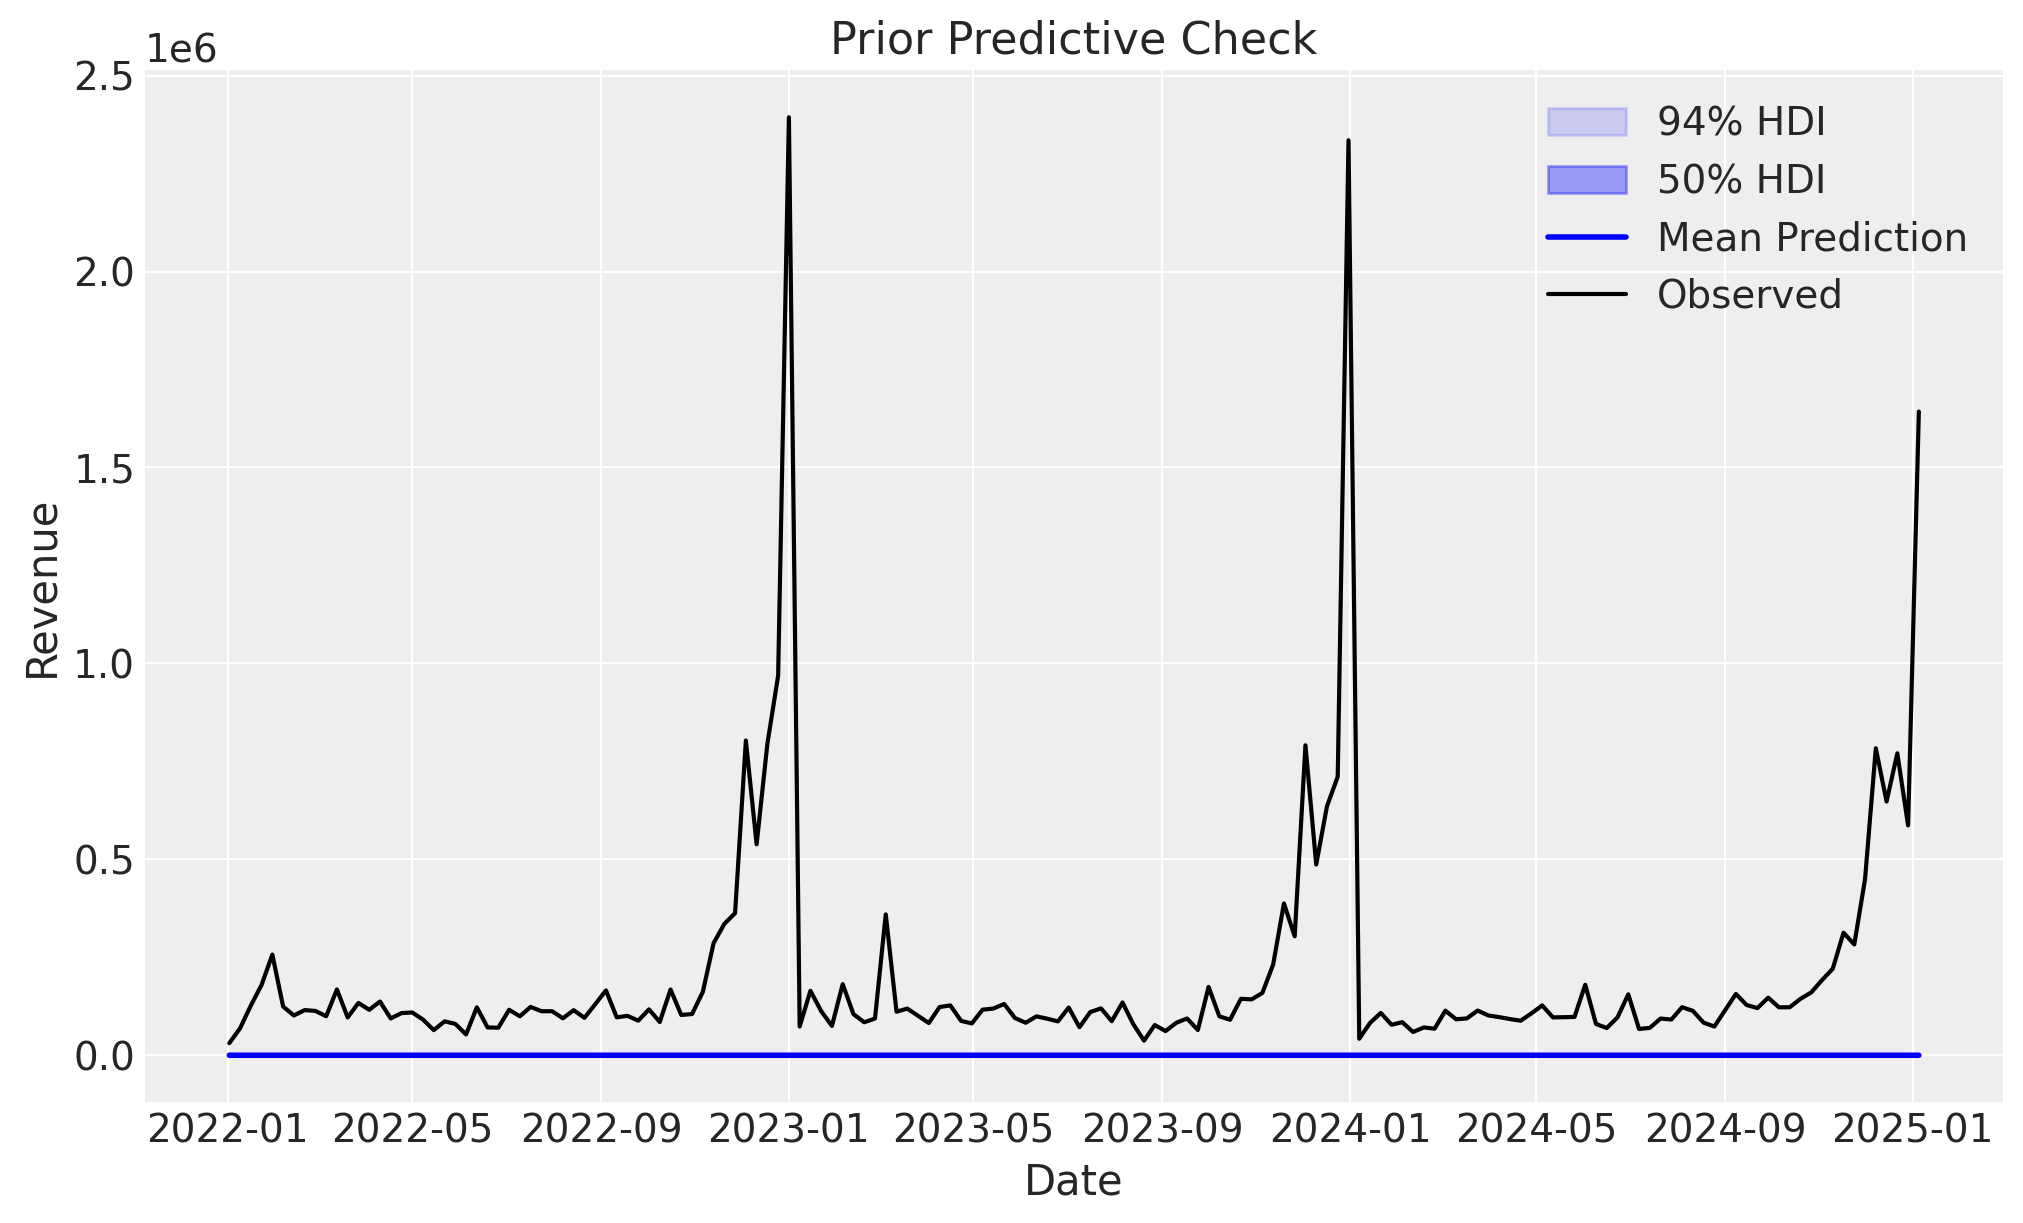

In [206]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

# 1) Extract the DataArray from your MMM object
prior_da = mmm.prior_predictive["y"]  # shape (chain=1, draw=6000, date=144)

# 2) Stack chain + draw into one dimension called "sample"
#    This will give us dims ("sample", "date"), e.g. (6000, 144)
y_stacked = prior_da.stack(sample=("chain", "draw"))
# Optionally transpose so "sample" is first, "date" is second (often default already):
y_stacked = y_stacked.transpose("sample", "date")

# 3) Convert the stacked DataArray to a NumPy array
#    Now shape is (6000, 144)
y_np = y_stacked.values

# 4) Compute the mean and high-density intervals across samples
mean_pred = y_np.mean(axis=0)              # shape (144,)
hdi_94 = az.hdi(y_np, hdi_prob=0.94)       # shape (144, 2)
hdi_50 = az.hdi(y_np, hdi_prob=0.50)       # shape (144, 2)

# 5) Prepare your "dates" array, which should match length 144
dates = X["Date"].values  # or df["Date"], or prior_da.coords["date"].values

# 6) Plot the ribbons and the observed log data
plt.figure(figsize=(10, 6))

# Fill 94% HDI
plt.fill_between(dates, hdi_94[:, 0], hdi_94[:, 1],
                 color="blue", alpha=0.15, label="94% HDI")

# Fill 50% HDI
plt.fill_between(dates, hdi_50[:, 0], hdi_50[:, 1],
                 color="blue", alpha=0.35, label="50% HDI")

# Plot mean prior prediction
plt.plot(dates, mean_pred, color="blue", lw=2, label="Mean Prediction")

# Plot the log-transformed observed data
plt.plot(dates, y, color="black", label="Observed")

plt.title("Prior Predictive Check")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.show()


In [207]:
print("y (target revenue) summary:")
print(y.describe())
print("y head:")
print(y.head())


y (target revenue) summary:
count    1.580000e+02
mean     2.059509e+05
std      3.218547e+05
min      3.082272e+04
25%      8.886205e+04
50%      1.123906e+05
75%      1.561885e+05
max      2.393697e+06
Name: Revenue, dtype: float64
y head:
0     30822.72
1     68907.69
2    126823.22
3    179726.72
4    256924.08
Name: Revenue, dtype: float64


In [208]:
#stop

In [209]:
mmm.fit(X=X, y=y, nuts_sampler="numpyro",target_accept=0.95, chains=4, draws=6_000, random_seed=rng)

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

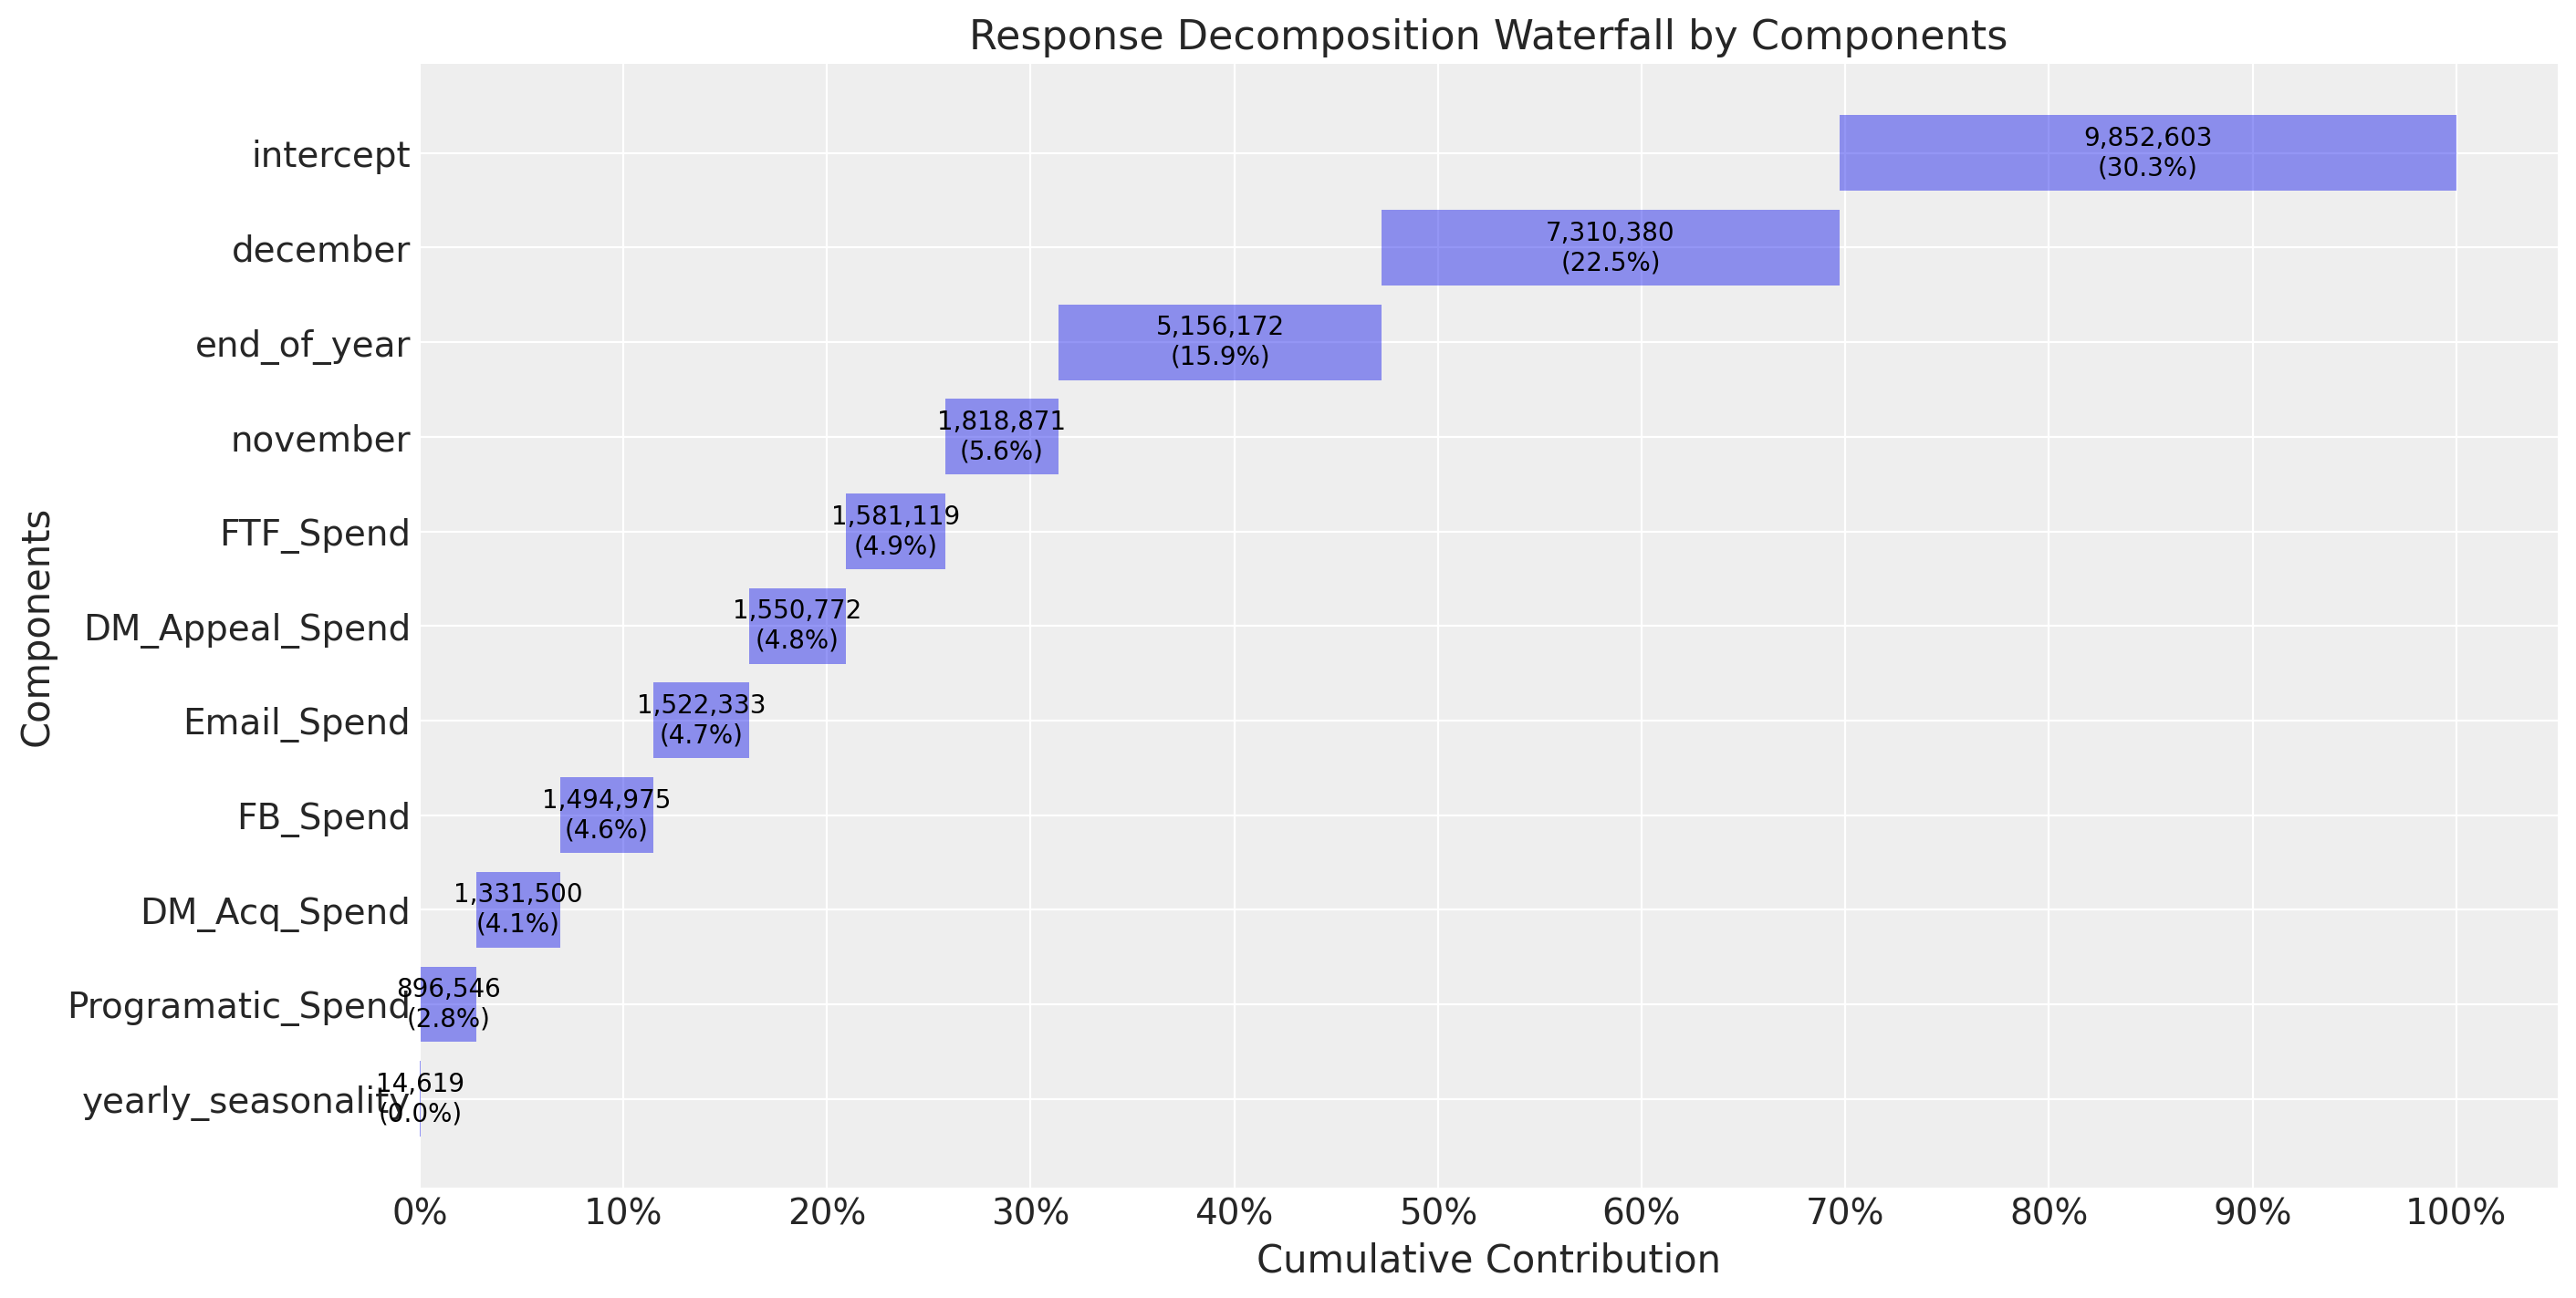

In [210]:
mmm.plot_waterfall_components_decomposition();

In [211]:
X['end_of_year'] = X['end_of_year'].astype(int)

Output()

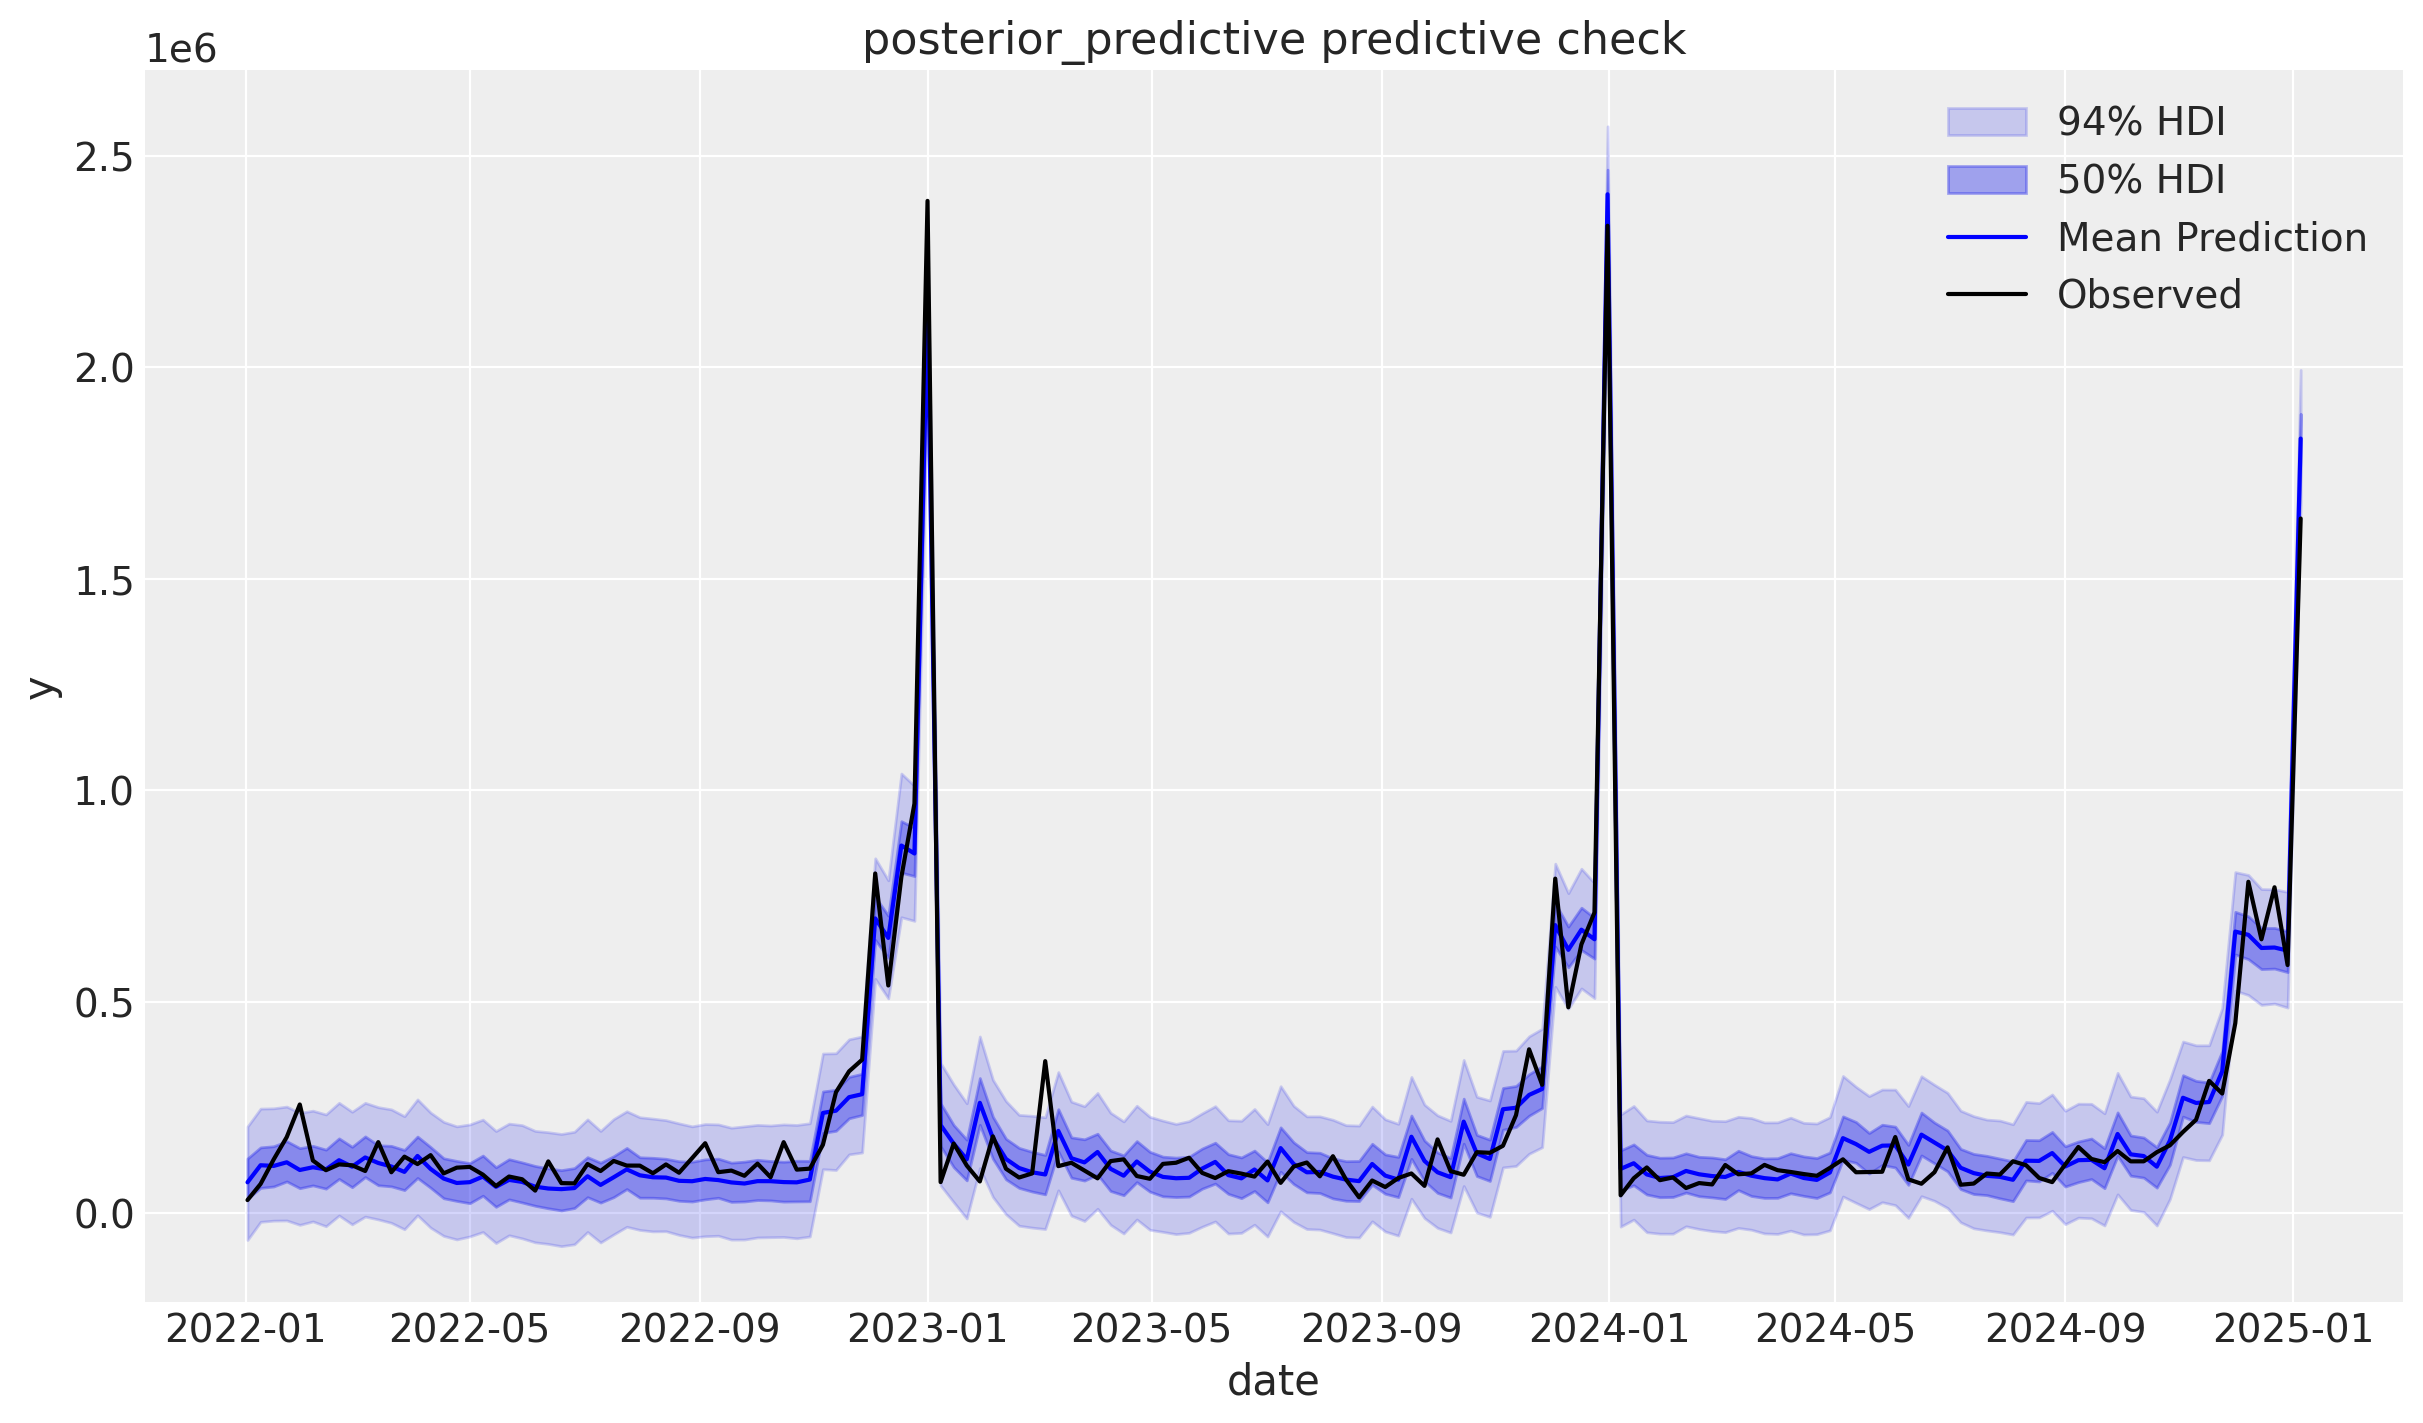

In [212]:
def get_posterior_check(mmm_):
  mmm_.sample_posterior_predictive(X, extend_idata=True, combined=True)
  mmm_.plot_posterior_predictive(original_scale=True);
get_posterior_check(mmm)

In [213]:
# Access the InferenceData object after fitting or sampling
idata = mmm.idata

# Print the observed data stored in ArviZ
print("ArviZ observed_data:")
print(idata.observed_data)

# Extract the 'y' variable from observed_data
observed_arviz = idata.observed_data["y"].values

# Compare the first few values to your original y
print("First 5 values in ArviZ observed data:", observed_arviz[:5])
print("First 5 values in original y:", y.values[:5])

# Check if they match (or are very close)
print("Are they equal?", np.allclose(observed_arviz, y.values, rtol=1e-5, atol=1e-5))


ArviZ observed_data:
<xarray.Dataset> Size: 3kB
Dimensions:  (date: 158)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2022-01-02 2022-01-09 ... 2025-01-05
Data variables:
    y        (date) float64 1kB 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    created_at:                 2025-03-16T22:35:54.884320+00:00
    arviz_version:              0.20.0
    inference_library:          pymc
    inference_library_version:  5.21.1
First 5 values in ArviZ observed data: [0. 0. 0. 0. 0.]
First 5 values in original y: [ 30822.72  68907.69 126823.22 179726.72 256924.08]
Are they equal? False


In [214]:
max_revenue = 2393697  # or calculate it from your data: df['Revenue'].max()
y_pred_raw = mmm.predict(X) * max_revenue


Output()

Output()

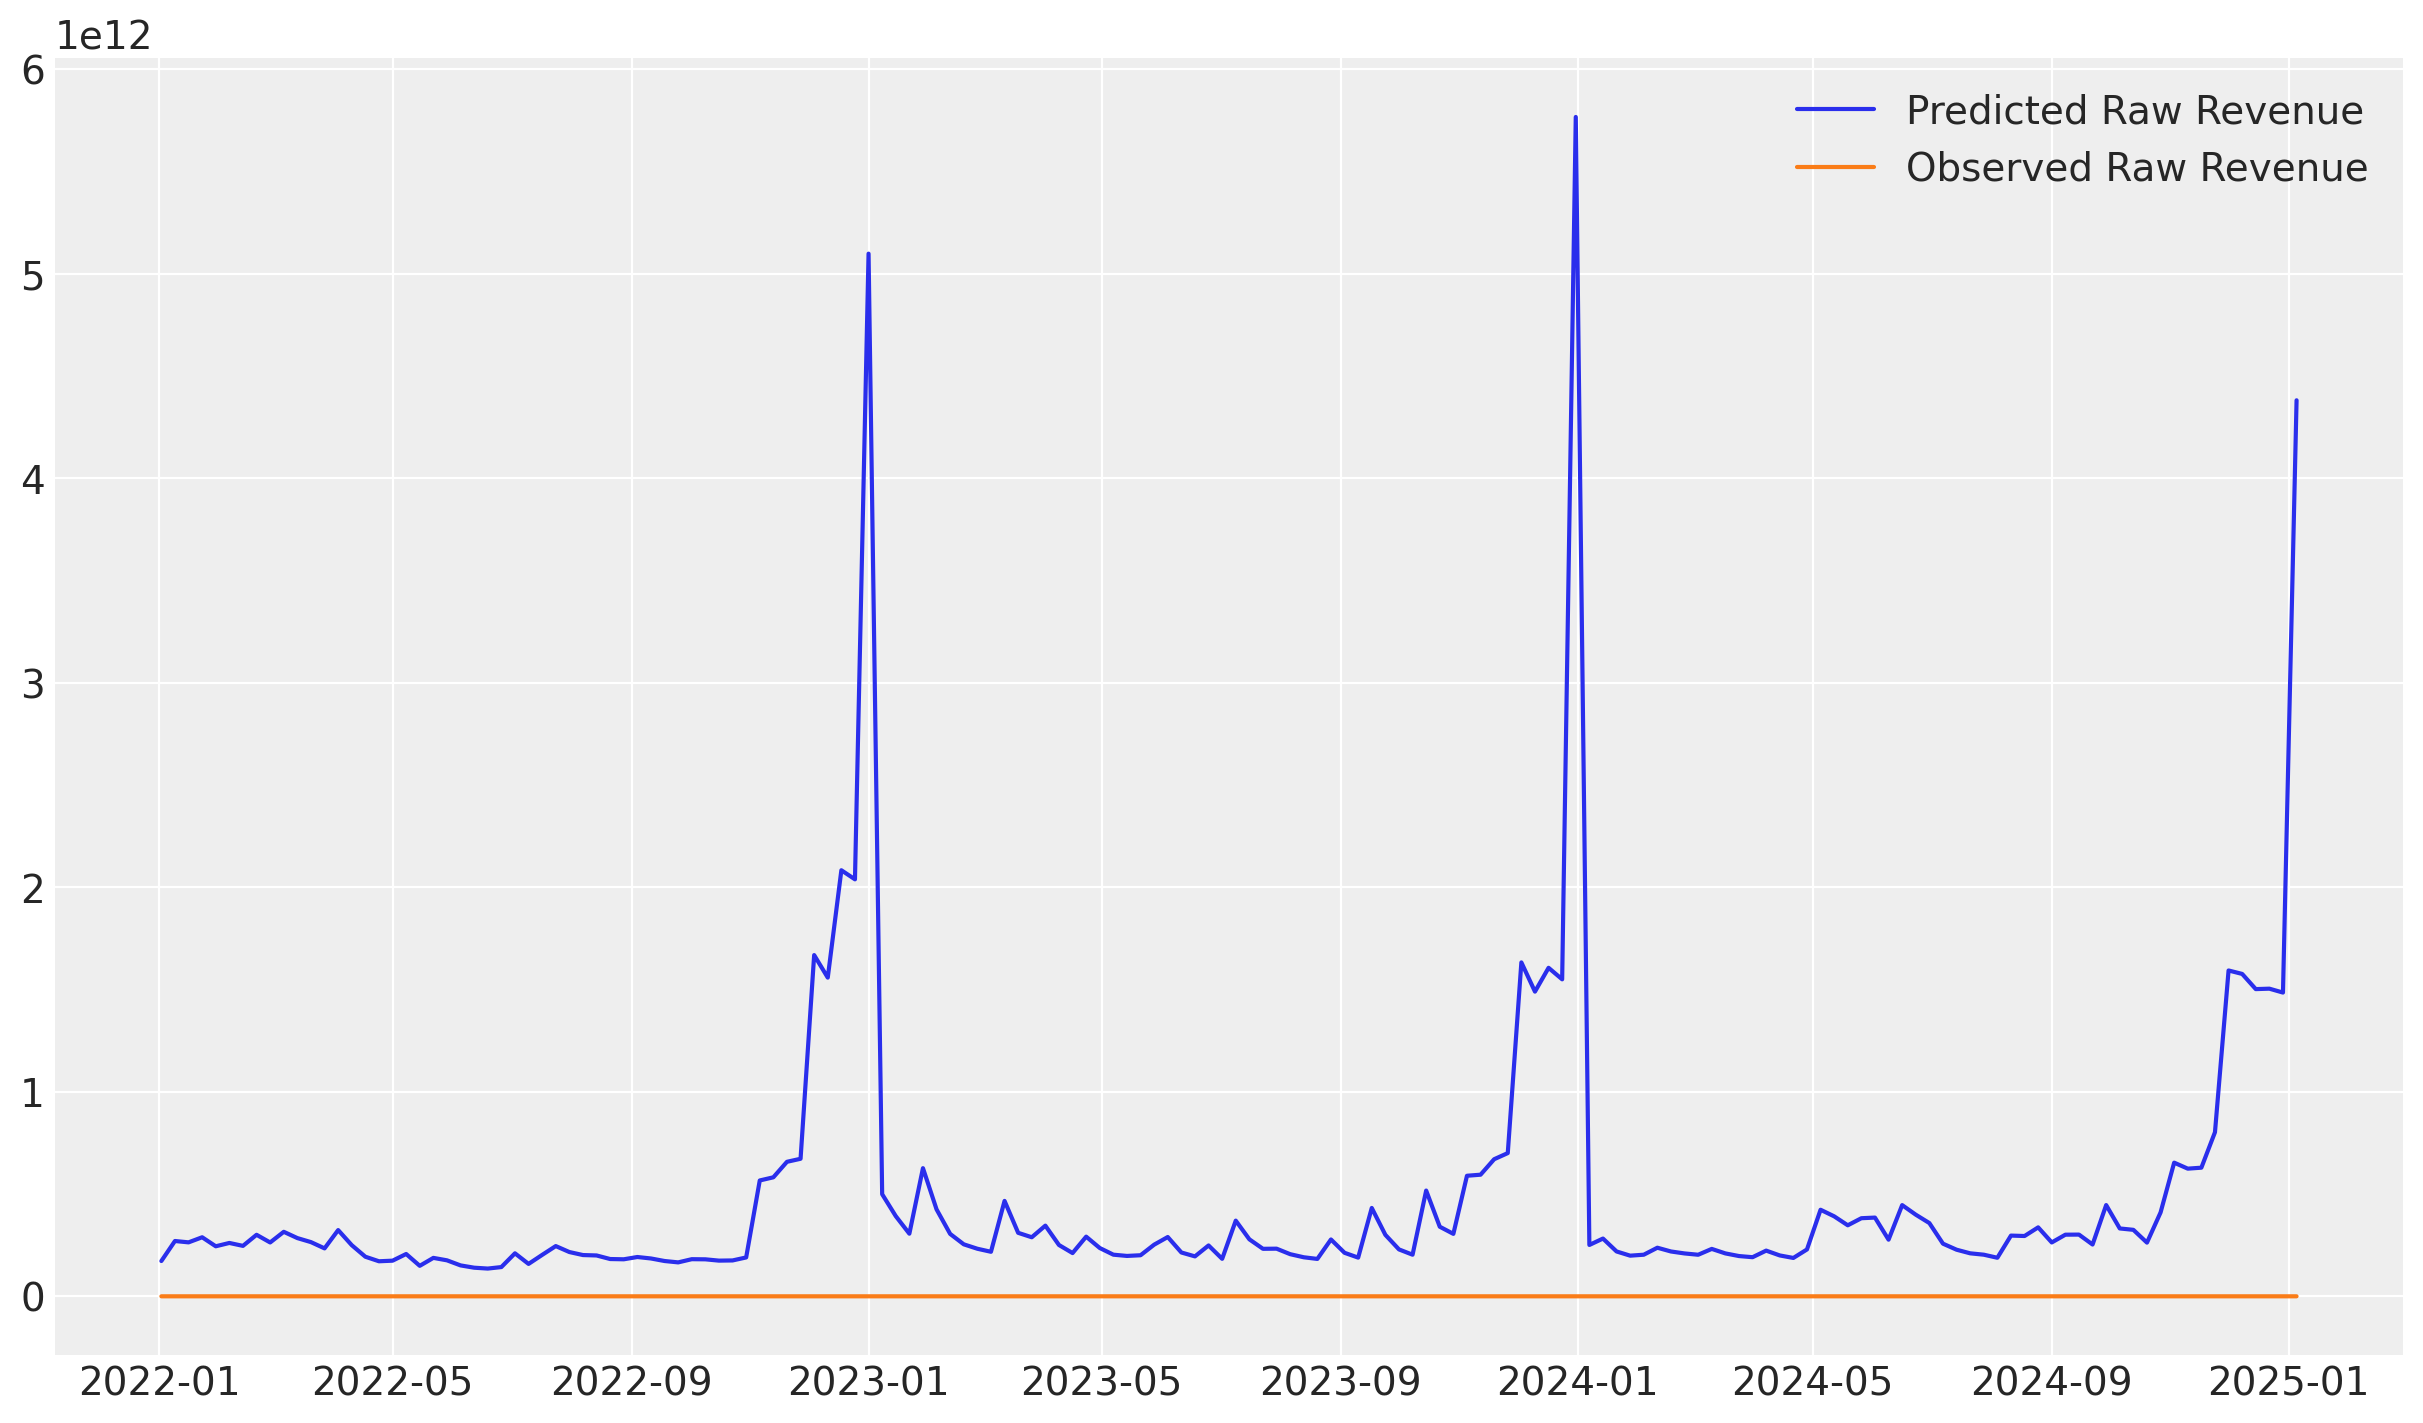

In [215]:
# Example: plotting posterior predictive on the raw scale
posterior_preds_normalized = mmm.predict(X)  # these are normalized
posterior_preds_raw = posterior_preds_normalized * max_revenue
plt.plot(X["Date"], posterior_preds_raw, label="Predicted Raw Revenue")
plt.plot(X["Date"], y, label="Observed Raw Revenue")
plt.legend()
plt.show()


In [216]:
#use these functions for raw revenue
from sklearn.metrics import r2_score

def get_mape(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print(f"MAPE: {mape}")

def get_r2(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    r2 = r2_score(y, y_pred)
    return r2

print(get_mape(mmm))
print(get_r2(mmm))


Output()

MAPE: 31.523546227892524
None


Output()

0.9597249355356038


In [217]:
stop

NameError: name 'stop' is not defined

In [ ]:
#mape and r2 for log

from sklearn.metrics import r2_score
import numpy as np

def get_mape(mmm_, X, y):
    """
    Computes MAPE on the raw (un-logged) scale.
      mmm_    : your MMM object
      X       : features DataFrame
      y       : log-transformed target (log_Revenue)
    """
    # 1) Get log-scale predictions
    y_pred_log = mmm_.predict(X)

    # 2) Convert both y and y_pred back to raw revenue
    y_true_raw  = np.exp(y) - 1
    y_pred_raw  = np.exp(y_pred_log) - 1

    # 3) Compute MAPE in raw space
    mape = np.mean(np.abs((y_true_raw - y_pred_raw) / y_true_raw)) * 100
    print(f"MAPE: {mape:.2f}%")
    return mape

def get_r2(mmm_, X, y):
    """
    Computes R^2 on the raw (un-logged) scale.
      mmm_    : your MMM object
      X       : features DataFrame
      y       : log-transformed target (log_Revenue)
    """
    y_pred_log = mmm_.predict(X)
    y_true_raw = np.exp(y) - 1
    y_pred_raw = np.exp(y_pred_log) - 1

    r2 = r2_score(y_true_raw, y_pred_raw)
    print(f"R²: {r2:.3f}")
    return r2

mape_value = get_mape(mmm, X, y)
r2_value   = get_r2(mmm, X, y)


In [ ]:
df_res = df[['Date']]
df_res['y'] = y
df_res['y_pred'] = mmm.predict(X)

In [ ]:
df_res

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_res['Date'], df_res['y'], label='y')
plt.plot(df['Date'], df_res['y_pred'], label='y_pred', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Model Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
custom_config = {
    # If you expect weekly revenue in the hundreds of thousands,
    # use a HalfNormal with a sigma big enough to capture that scale:
    "intercept": {
    "dist": "Normal",
    "kwargs": {"mu": 700000, "sigma": 300000}
    },
    # The noise in raw revenue can be large, so let sigma_obs be wide as well.
    "sigma_obs": Prior("HalfNormal", sigma=1e5),

    # Saturation hyperparameters might still be okay, but you can tweak them if needed
    "saturation_beta": Prior("Gamma", sigma=5, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=4, beta=4, dims="channel"),

    # If you still want control variables in raw scale, keep the gamma priors
    "gamma_control": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": 5e5}
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 2}
    },

    "time_varying_intercept_sigma": {
        "dist": "HalfNormal",
       "kwargs": {"sigma": 2e6}  # or larger if December leaps by millions
    }

}

In [ ]:
custom_config = {
    "intercept": {
        "dist": "Normal",
        "kwargs": {"mu": 110000, "sigma": 50000} # Lowered baseline to match typical weeks
    },
    "sigma_obs": Prior("HalfNormal", sigma=1e5),  # Increased to reflect observed variability
    "saturation_beta": Prior("Gamma", sigma=5, dims="channel"),
    "saturation_lam": Prior("Gamma", alpha=4, beta=4, dims="channel"),
    "gamma_control": {
        "dist": "Normal",   # Allow both positive and negative adjustments
        "kwargs": {"mu": 0, "sigma": 1e6}  # Broader for large holiday effects
    },
    "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": {"mu": 0, "b": 2}  # You might experiment with b if seasonality is misfitting
    },
    "time_varying_intercept_sigma": {
        "dist": "HalfNormal",
        "kwargs": {"sigma": 1e5}  # Reduced a bit from 2e6 to prevent extreme jumps outside holiday periods
    }
}

# Suppose your DataFrame is named df, sorted by date.
# Columns: ['Date', 'DM_Impressions', 'Email_Impressions', ..., 'Revenue', etc.]
# We'll create X and y, BUT keep "Date" in X.

# 1) Identify numeric columns for the model (channels, controls), but DO NOT include 'Date' in them.
#defined above
ch = [ 'DM_Appeal_Spend', 'DM_Acq_Spend', 'Email_Spend',
       'FB_Spend',  'Programatic_Spend',
       'FTF_Spend']

controls = ['giving_tuesday', "eoy_campaign"]

mmm = MMM(
    model_config=custom_config,
    sampler_config={"progressbar": True},
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=controls,
    yearly_seasonality=2,
    time_varying_media=False,
    time_varying_intercept=True
)
